# Training
In this section, we provide examples about how to use common RL frameworks to train autonomous driving policy.

## stable-baselines3
[stable-baselines3](https://github.com/DLR-RM/stable-baselines3) is a lightweight RL training framework, providing most of the commonly used algorithms. It is easy to use on desktop PC, personal laptops, and single node servers. 

Training a driving agent with *stable-baselines3* is easy and straightforward. In the following example, we train an agent to drive in about 5 minutes.
Let's first create a simple environment.

pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/shady/data/miniconda/envs/metadrive/lib/python3.7/site-packages/torch/utils/tensorboard/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  tensorboard.__version__


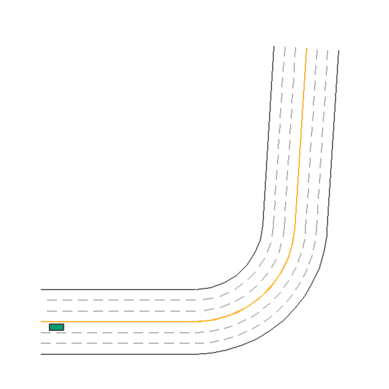

In [1]:
from metadrive.envs import MetaDriveEnv
from metadrive.policy.lange_change_policy import LaneChangePolicy
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from metadrive.component.map.base_map import BaseMap
from metadrive.utils import generate_gif
from IPython.display import Image

def create_env(need_monitor=False):
    env = MetaDriveEnv(dict(map="C",
                      # This policy setting simplifies the task                      
                      discrete_action=True,
                      discrete_throttle_dim=3,
                      discrete_steering_dim=3,
                      horizon=500,
                      # scenario setting
                      random_spawn_lane_index=False,
                      num_scenarios=1,
                      start_seed=5,
                      traffic_density=0,
                      accident_prob=0,
                      log_level=50))
    if need_monitor:
        env = Monitor(env)
    return env

env=create_env()
env.reset()
ret = env.render(mode="topdown", 
                 no_window=True,
                 screen_size=(600, 600), 
                 camera_position=(50, 50))
env.close()
plt.axis("off")
plt.imshow(ret)

The goal of this agent is driving from left-side to right-side without any collisions with the breakdown vehicle. Thus it needs learn to sidestep it. Before the training, let's install the *stable-baselines3* and dependencies at first.

In [ ]:
%pip install stable-baselines3[extra]

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from functools import partial
from IPython.display import clear_output
import os

set_random_seed(0)
# 4 subprocess to rollout
train_env=SubprocVecEnv([partial(create_env, True) for _ in range(4)]) 
model = PPO("MlpPolicy", 
            train_env,
            n_steps=4096,
            verbose=1)
model.learn(total_timesteps=1000 if os.getenv('TEST_DOC') else 300_000,
            log_interval=4)

clear_output()
print("Training is finished! Generate gif ...")

# evaluation
total_reward = 0
env=create_env()
obs, _ = env.reset()
try:
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        total_reward += reward
        ret = env.render(mode="topdown", 
                         screen_record=True,
                         no_window=True,
                         screen_size=(600, 600), 
                         camera_position=(50, 50))
        if done:
            print("episode_reward", total_reward)
            break
            
    env.top_down_renderer.generate_gif()
finally:
    env.close()
print("gif generation is finished ...")

Using cuda device
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 159         |
|    ep_rew_mean          | 60.2        |
| time/                   |             |
|    fps                  | 1114        |
|    iterations           | 10          |
|    time_elapsed         | 147         |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.014892737 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.509       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.02        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 6.71        |
-----------------------------------------


In [ ]:
Image(open("demo.gif", 'rb').read())

## ray/rllib

We provide a script demonstrating how to use [RLLib>=2.2.0](https://docs.ray.io/en/latest/rllib.html) to train generalizable RL agents:

```bash
# Make sure current folder does not have a sub-folder named metadrive
python -m metadrive.examples.train_generalization_experiment

# You can also use GPUs and customized experiment name:
python -m metadrive.examples.train_generalization_experiment \
 --exp-name CUSTOMIZED_EXP_NAME \
 --num-gpus HOW_MANY_GPUS_IN_THIS_MACHINES
```

In this example, we leave the training hyper-parameter `config["num_envs_per_worker"] = 1` as default, so that each process (ray worker) will only contain one MetaDrive instance.
We further set the evaluation workers `config["evaluation_num_workers"] = 5`, so that the test set environments are hosted in separated processes.
By utilizing the feature of RLLib, we avoid the issue of multiple MetaDrive instances in single process. 

We welcome more examples using MetaDrive in different context! Please show off your code if you like to share it by opening new issue! Thanks!